In [ ]:
# Tutorial: https://www.youtube.com/watch?v=2XGSIlgUBDI

## ARIMA and Seasonal ARIMA


In [ ]:
## Autorigressive Integrated Moving Averages
# The steps involved in ARIMA models are:
    # visualizing the time series
    # If not stationary, making the time series data stationary
    # plotting the correlation and autoCorrelation charts
    # consturcting the ARIMA model or seasonal ARIMA based on the data
    # Finally using the data to make predictions

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/perrin-freres-monthly-champagne-.csv')

In [ ]:
data.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [ ]:
data.tail()
# we need to remove the last 2 records

,Month,Perrin Freres monthly champagne sales millions ?64-?72
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0
105,NaN,NaN
106,Perrin Freres monthly champagne sales millions...,NaN


In [ ]:
# changing the column names
data.columns = ['Month', 'Sales']

In [ ]:
# dropping the NaN rows from the end
data.drop(105, axis=0, inplace=True)
data.drop(106, axis=0, inplace=True)
data.tail()

,Month,Sales
100,1972-05,4618.0
101,1972-06,5312.0
102,1972-07,4298.0
103,1972-08,1413.0
104,1972-09,5877.0


In [ ]:
# transforming the data column into datetime datatype
data['Month'] = pd.to_datetime(data['Month'])

In [ ]:
data.head()

,Month,Sales
0,1964-01-01,2815.0
1,1964-02-01,2672.0
2,1964-03-01,2755.0
3,1964-04-01,2721.0
4,1964-05-01,2946.0


In [ ]:
# setting the datetime column to index
data.set_index('Month', inplace=True) 

In [ ]:
data.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


## Visualisation of Data

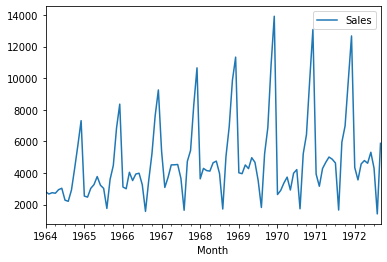

In [ ]:
data.plot()
# Data has the seasonality component

In [ ]:
# testing the stationarity
from statsmodels.tsa.stattools import adfuller
test_result = adfuller(data['Sales'])

In [ ]:
# H0: It is not stationary
# H1: It is stationary

display(test_result[1]) #p-value
display(test_result[2]) #lags used
display(test_result[3]) # number of observations used

# since p-value is greater than 0.05, we fail to reject the null hypothesis
# data is non-stationary

0.363915771660245

11

93

In [ ]:
# Function to test stationarity using probability test

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations']
    for value,label in zip(result,labels):
        print(label+' : '+str(value))

    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
    else:
        print("weak evidence against null hypothesis,indicating it is non-stationary ")

adfuller_test(data['Sales'])

ADF Test Statistic : -1.8335930563276228
p-value : 0.363915771660245
#Lags Used : 11
Number of Observations : 93
weak evidence against null hypothesis,indicating it is non-stationary 


## Steps to make data stationary


1.   Differencing (by shifting position)



In [ ]:
data['Sales_first_diff'] = data['Sales'] - data['Sales'].shift(1)

In [ ]:
# Instead of blindly shifting by 1
# we will do "seasonal shifting", i.e., shifting by 12
data['Seasonal_first_diff'] = data['Sales'] - data['Sales'].shift(12)

In [ ]:
data.head(13)

,Sales,Sales_first_diff,Seasonal_first_diff
Month,,,
1964-01-01,2815.0,NaN,NaN
1964-02-01,2672.0,-143.0,NaN
1964-03-01,2755.0,83.0,NaN
1964-04-01,2721.0,-34.0,NaN
1964-05-01,2946.0,225.0,NaN
1964-06-01,3036.0,90.0,NaN
1964-07-01,2282.0,-754.0,NaN
1964-08-01,2212.0,-70.0,NaN
1964-09-01,2922.0,710.0,NaN


In [ ]:
# performing dickey fuller test to check if data has become stationary
# testing the stationarity
from statsmodels.tsa.stattools import adfuller
test_result = adfuller(data['Seasonal_first_diff'].dropna()) #dropping null values

# H0: It is not stationary
# H1: It is stationary

display(test_result[1]) #p-value
display(test_result[2]) #lags used
display(test_result[3]) # number of observations used

# since p-value is less than 0.05, we can reject the null hypothesis
# data is stationary now

2.060579696813685e-11

0

92

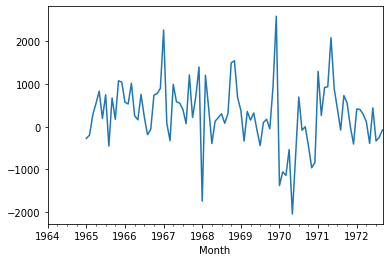

In [ ]:
data['Seasonal_first_diff'].plot()
#plot seems stationary

## Auto-Regressive Model: aim is to find 'how many lags or previous data we need to consider, to predict future data'

In [ ]:
# Identification of AR model is often best done with PACF.
    # For an AR model, the theoretical PACF "shuts off" past order of the model.
    # The phrase "shuts off" means that in theory the partial autocorrelations are equal to 0 beyond that point.
    # i.e., the number of non-zero partial auto-correlations gives the order of the AR model
    # "order of the model" - means the most extreme lag of x that is used as predictor

# Identification of MA model is often best done with ACF
    # A cleaner pattern for an MA model is ACF. The ACF will have non-zero auto-correlations only at lags involved in the model

# # sudden shutdown occurs at lags=1 Partial autocorrelation, cause after that all the values are less than blue shade
# at lags=1, the tip touches the boundary or is above blue shade

# ** auto-correlation must decrease exponentially (from a high tower to just touching blue shade tip)

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

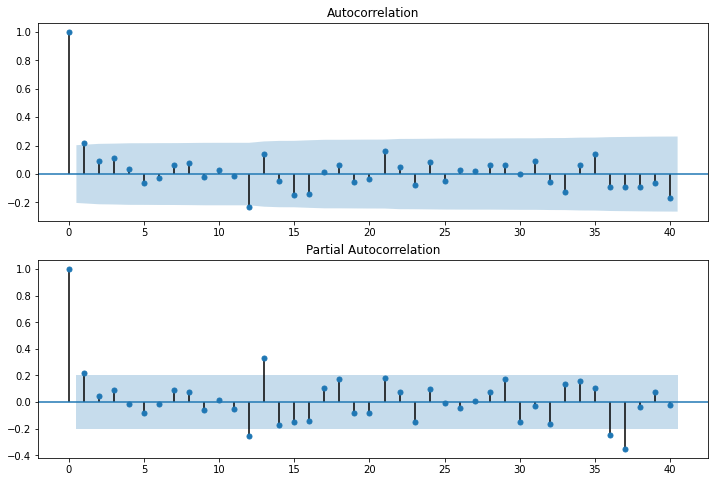

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(data['Seasonal_first_diff'].dropna(), lags=40, ax=ax1)

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(data['Seasonal_first_diff'].dropna(), lags=40, ax=ax2)

# sudden shutdown occurs at lags=1 Partial autocorrelation, cause after that all the values are less than blue shade
# at lags=1, the tip touches the boundary or is above blue shade

In [ ]:
# ARIMA model
# p - AR model lags (from pacf) = 1
# d - differencing = 1 [this is because we just did 1 seasonal differencing in order to make the data stationary (constant mean and variance)]
# q - MA lags (from acf) = 1

## ARIMA model
##### ** ARIMA should be selected only when data is not "seasonal"

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

In [ ]:
# although data is seasonal, we are using ARIMA for comparison purpose
# N.B: We should not use ARIMA in real life, if the data holds seasonality

model = ARIMA(data['Sales'], order=(1,1,1))
model_fit = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                D.Sales   No. Observations:                  104
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -951.126
Method:                       css-mle   S.D. of innovations           2227.262
Date:                Wed, 25 Aug 2021   AIC                           1910.251
Time:                        11:30:12   BIC                           1920.829
Sample:                    02-01-1964   HQIC                          1914.536
                         - 09-01-1972                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            22.7848     12.405      1.837      0.069      -1.529      47.099
ar.L1.D.Sales     0.4343      0.089      4.866      0.000       0.259       0.609
ma.L1.D.Sales    -1.0000      0.026    -38.503      0.000      -1.051      -0.949
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3023           +0.0000j            2.3023            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

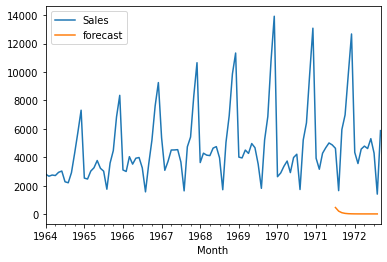

In [ ]:
data['forecast'] = model_fit.predict(start=90, end=103, dynamic=True) # start and end are index
data[['Sales', 'forecast']].plot()
# wrong prediction

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


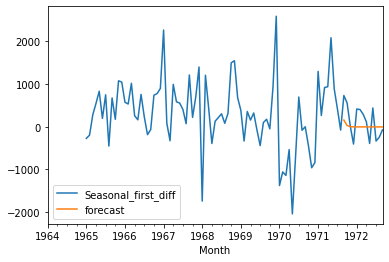

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

# although data is seasonal, we are using ARIMA for comparison purpose
# N.B: We should not use ARIMA in real life, if the data holds seasonality

model = ARIMA(data['Seasonal_first_diff'].dropna(), order=(1,1,1))
model_fit = model.fit()

data['forecast'] = model_fit.predict(start=80, end=103, dynamic=True) # start and end are index
data[['Seasonal_first_diff', 'forecast']].plot()
# wrong prediction

#### Taking back to original series

In [ ]:
ARIMA_diff_predictions = pd.Series(model_fit.fittedvalues, copy=True) # we first converted the fitted values to series
print(ARIMA_diff_predictions.head())

Month
1965-02-01     -4.875690
1965-03-01    -37.538777
1965-04-01   -273.230926
1965-05-01   -371.430846
1965-06-01   -483.507598
dtype: float64


In [ ]:
ARIMA_diff_predictions_cumsum = ARIMA_diff_predictions.cumsum() # then we took the cumulative sum
print(ARIMA_diff_predictions_cumsum.head())

Month
1965-02-01      -4.875690
1965-03-01     -42.414468
1965-04-01    -315.645394
1965-05-01    -687.076239
1965-06-01   -1170.583837
dtype: float64


In [ ]:
ARIMA_diff_predictions_cumsum.isnull().sum()

0

In [ ]:
data.shape

(105, 5)

In [ ]:
data.iloc[:12,0].values

array([2815., 2672., 2755., 2721., 2946., 3036., 2282., 2212., 2922.,
       4301., 5764., 7312.])

In [ ]:
values = data.iloc[:12,0].tolist() * 9
first_val = pd.Series(values[:len(values)-3], index=data.index) # a series of first 12 values repeated
 # because the first 12 elements were removed; so it was added to all values
first_val[:24]

Month
1964-01-01    2815.0
1964-02-01    2672.0
1964-03-01    2755.0
1964-04-01    2721.0
1964-05-01    2946.0
1964-06-01    3036.0
1964-07-01    2282.0
1964-08-01    2212.0
1964-09-01    2922.0
1964-10-01    4301.0
1964-11-01    5764.0
1964-12-01    7312.0
1965-01-01    2815.0
1965-02-01    2672.0
1965-03-01    2755.0
1965-04-01    2721.0
1965-05-01    2946.0
1965-06-01    3036.0
1965-07-01    2282.0
1965-08-01    2212.0
1965-09-01    2922.0
1965-10-01    4301.0
1965-11-01    5764.0
1965-12-01    7312.0
dtype: float64

In [ ]:
ARIMA_prediction = first_val.add(ARIMA_diff_predictions_cumsum,fill_value=0) #element wise addition; fill_value = 0 -- fill missing values with 0
ARIMA_prediction.head(16)

Month
1964-01-01    2815.000000
1964-02-01    2672.000000
1964-03-01    2755.000000
1964-04-01    2721.000000
1964-05-01    2946.000000
1964-06-01    3036.000000
1964-07-01    2282.000000
1964-08-01    2212.000000
1964-09-01    2922.000000
1964-10-01    4301.000000
1964-11-01    5764.000000
1964-12-01    7312.000000
1965-01-01    2815.000000
1965-02-01    2667.124310
1965-03-01    2712.585532
1965-04-01    2405.354606
dtype: float64

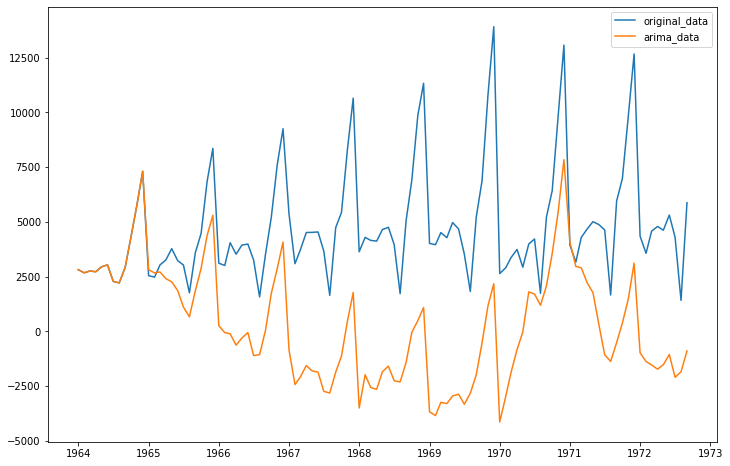

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(data['Sales'], label="original_data")
plt.plot(ARIMA_prediction, label="arima_data")
plt.legend(loc='best')


## Seasonal ARIMA model

In [ ]:
import statsmodels.api as sm

In [ ]:
model = sm.tsa.statespace.SARIMAX(data['Sales'], order=(1,1,1), seasonal_order=(1,1,1,12))
# 12 - for the seasonal value
results = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


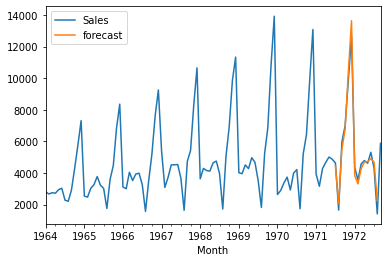

In [ ]:
data['forecast'] = results.predict(start=90, end=103, dynamic=True)
data[['Sales', 'forecast']].plot()

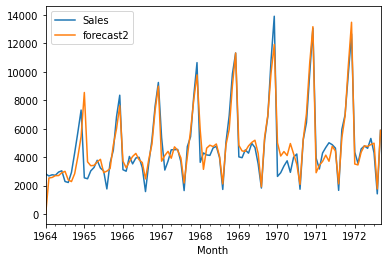

In [ ]:
data['forecast2'] = pd.Series(results.fittedvalues, copy=True)
data[['Sales', 'forecast2']].plot()

In [ ]:
# creating additional dataset for 24 months
from pandas.tseries.offsets import DateOffset
future_dates = [data.index[-1] + DateOffset(months = x) for x in range(1,25)]

In [ ]:
future_dates

[Timestamp('1972-10-01 00:00:00'),
 Timestamp('1972-11-01 00:00:00'),
 Timestamp('1972-12-01 00:00:00'),
 Timestamp('1973-01-01 00:00:00'),
 Timestamp('1973-02-01 00:00:00'),
 Timestamp('1973-03-01 00:00:00'),
 Timestamp('1973-04-01 00:00:00'),
 Timestamp('1973-05-01 00:00:00'),
 Timestamp('1973-06-01 00:00:00'),
 Timestamp('1973-07-01 00:00:00'),
 Timestamp('1973-08-01 00:00:00'),
 Timestamp('1973-09-01 00:00:00'),
 Timestamp('1973-10-01 00:00:00'),
 Timestamp('1973-11-01 00:00:00'),
 Timestamp('1973-12-01 00:00:00'),
 Timestamp('1974-01-01 00:00:00'),
 Timestamp('1974-02-01 00:00:00'),
 Timestamp('1974-03-01 00:00:00'),
 Timestamp('1974-04-01 00:00:00'),
 Timestamp('1974-05-01 00:00:00'),
 Timestamp('1974-06-01 00:00:00'),
 Timestamp('1974-07-01 00:00:00'),
 Timestamp('1974-08-01 00:00:00'),
 Timestamp('1974-09-01 00:00:00')]

In [ ]:
# creating a dataframe from future dates (excluding the first one)
future_dataframe = pd.DataFrame(index = future_dates[:], columns= data.columns)

In [ ]:
future_dataframe

,Sales,Sales_first_diff,Seasonal_first_diff,forecast
1972-10-01,NaN,NaN,NaN,NaN
1972-11-01,NaN,NaN,NaN,NaN
1972-12-01,NaN,NaN,NaN,NaN
1973-01-01,NaN,NaN,NaN,NaN
1973-02-01,NaN,NaN,NaN,NaN
1973-03-01,NaN,NaN,NaN,NaN
1973-04-01,NaN,NaN,NaN,NaN
1973-05-01,NaN,NaN,NaN,NaN
1973-06-01,NaN,NaN,NaN,NaN
1973-07-01,NaN,NaN,NaN,NaN


In [ ]:
future_data = pd.concat([data, future_dataframe])

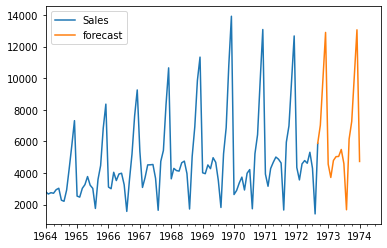

In [ ]:
# predicting the future values
future_data['forecast'] = results.predict(start=104, end=120, dynamic=True)
future_data[['Sales', 'forecast']].plot()